# 1. Loading files

In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, MaxPool1D, Flatten, Dropout,Conv1D , BatchNormalization,Input
from keras.models import Sequential,Model # importing dense layer
# representation of model layers
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import xgboost

In [2]:
import os
import csv

def append_csv_files(directory, output_file):
    # Get list of all CSV files in the specified directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    
    # Check if there are CSV files in the directory
    if not csv_files:
        print("No CSV files found in the directory.")
        return
    
    # Open the output file in 'append' mode
    with open(output_file, 'a', newline='') as outfile:
        # Initialize CSV writer
        csv_writer = csv.writer(outfile)
        
        # Iterate over each CSV file
        for csv_file in csv_files:
            with open(os.path.join(directory, csv_file), 'r', newline='') as infile:
                # Initialize CSV reader
                csv_reader = csv.reader(infile)
                
                # Skip the header if it's not the first file
                if os.path.getsize(output_file) > 0:
                    next(csv_reader)
                
                # Write rows from the current CSV file to the output file
                for row in csv_reader:
                    csv_writer.writerow(row)

    print("CSV files have been successfully appended to", output_file)

# Example usage
directory = 'data_set_test/'
output_file = 'combined_file_test.csv'
append_csv_files(directory, output_file)


CSV files have been successfully appended to combined_file_test.csv


In [2]:
output_file = 'combined_file_test.csv'
df = pd.read_csv(output_file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732750 entries, 0 to 732749
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    732750 non-null  float64
 1   Header_Length    732750 non-null  float64
 2   Protocol Type    732750 non-null  float64
 3   Duration         732750 non-null  float64
 4   Rate             732750 non-null  float64
 5   Srate            732750 non-null  float64
 6   Drate            732750 non-null  float64
 7   fin_flag_number  732750 non-null  float64
 8   syn_flag_number  732750 non-null  float64
 9   rst_flag_number  732750 non-null  float64
 10  psh_flag_number  732750 non-null  float64
 11  ack_flag_number  732750 non-null  float64
 12  ece_flag_number  732750 non-null  float64
 13  cwr_flag_number  732750 non-null  float64
 14  ack_count        732750 non-null  float64
 15  syn_count        732750 non-null  float64
 16  fin_count        732750 non-null  floa

C:\Users\Viet Anh Phan\AppData\Local\Temp\ipykernel_18424\3327028950.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')


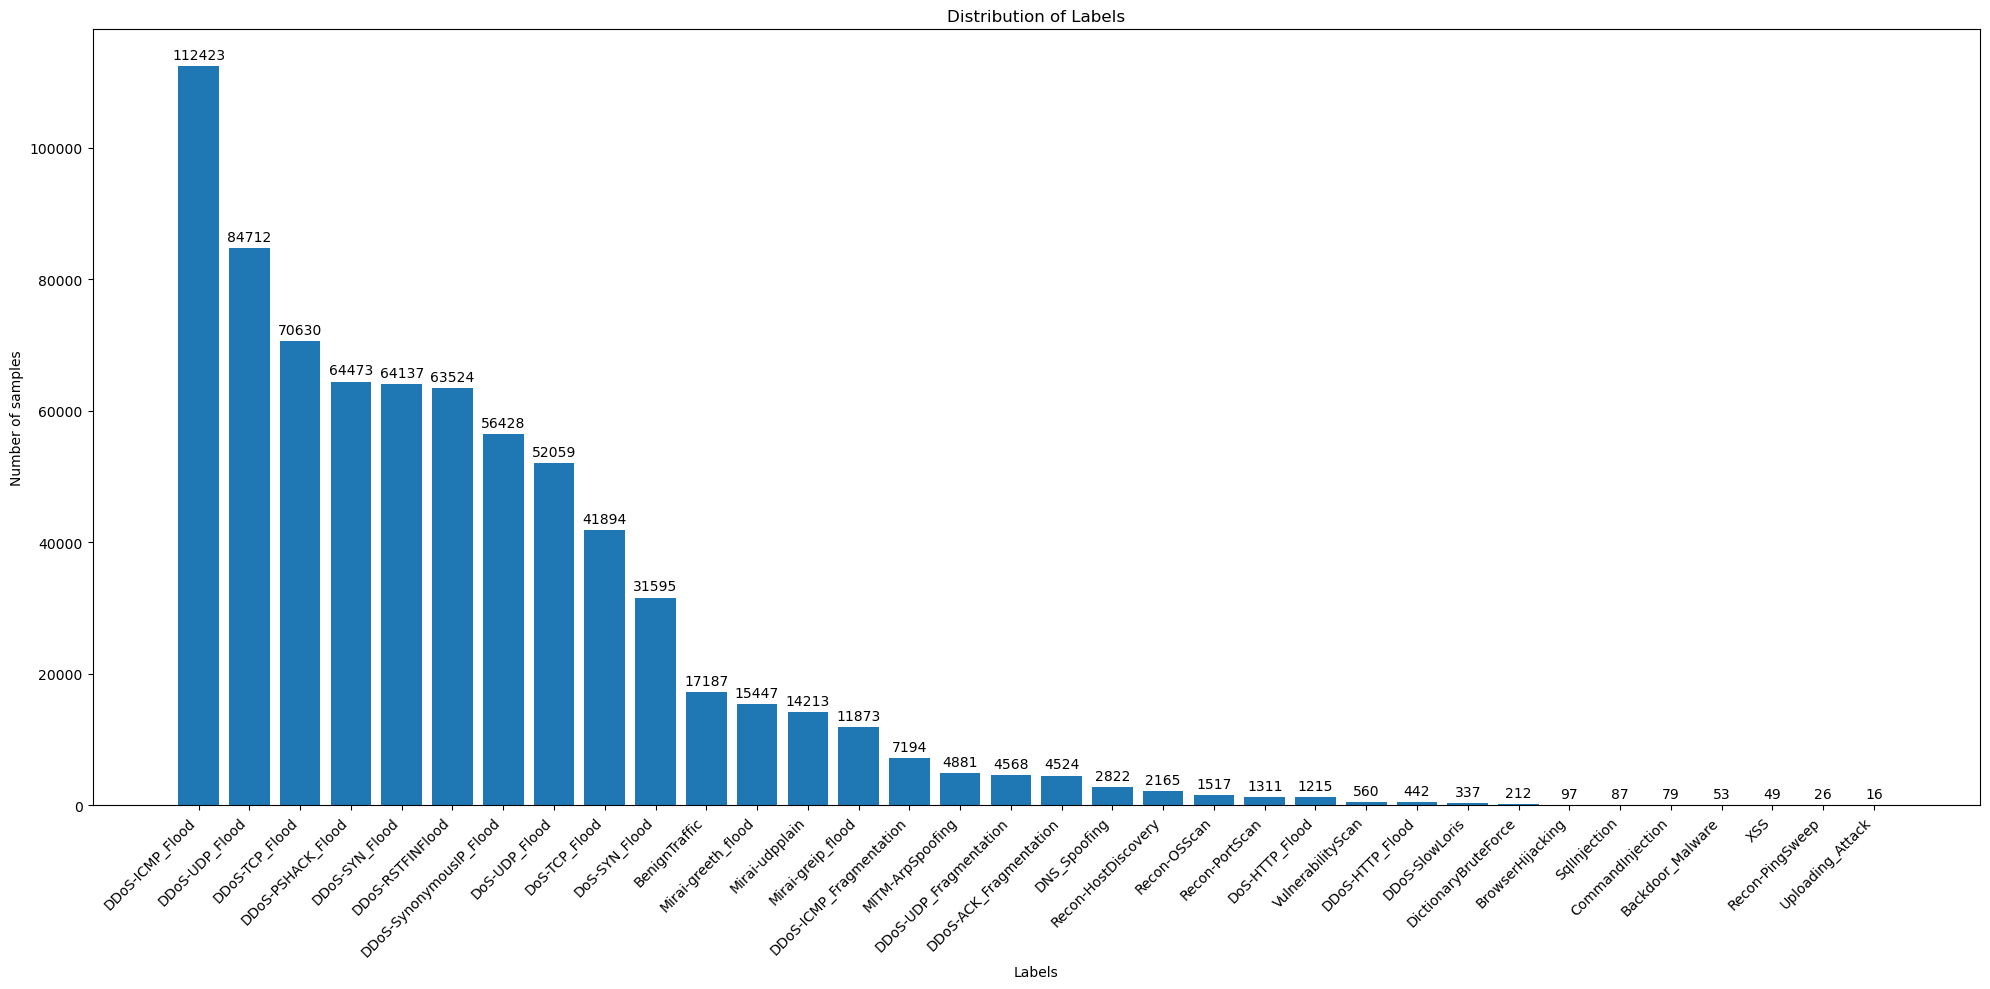

In [4]:
# Showing the graph about the dataset
fig, ax = plt.subplots(figsize=(20, 10))
bars = ax.bar(df["label"].value_counts().index, df["label"].value_counts().values, width=0.8)

# Rotating the x axis to see the label
ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')

# Formatting axis y
ax.yaxis.set_major_formatter('{:.0f}'.format)

# Adding label and title
ax.set_xlabel('Labels')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of Labels')

# Showing the exact number of attacks
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('attacks_list.png')

plt.show()

# 2. Reducing labels, appending similar attacks to 1 type

In [3]:
def change_label(df):
  df.label.replace(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DDoS-RSTFINFlood','DDoS-SynonymousIP_Flood','DDoS-ICMP_Fragmentation','DDoS-UDP_Fragmentation','DDoS-ACK_Fragmentation','DDoS-HTTP_Flood','DDoS-SlowLoris'],'DDos',inplace=True)
  df.label.replace(['DoS-UDP_Flood','DoS-TCP_Flood','DoS-SYN_Flood','DoS-HTTP_Flood'],'DoS',inplace=True)      
  df.label.replace(['Recon-HostDiscovery','Recon-OSScan','Recon-PortScan','Recon-PingSweep','VulnerabilityScan'],'Recon',inplace=True)
  df.label.replace(['MITM-ArpSpoofing','DNS_Spoofing'],'Spoofing',inplace=True)
  df.label.replace(['DictionaryBruteForce'],'BruteForce',inplace=True)
  df.label.replace(['BrowserHijacking','XSS','Uploading_Attack','SqlInjection','CommandInjection','Backdoor_Malware'],'Web-based',inplace=True)
  df.label.replace(['Mirai-greeth_flood','Mirai-udpplain','Mirai-greip_flood'],'Mirai',inplace=True)
  df.label.replace(['BenignTraffic'],'BENIGN',inplace=True)
change_label(df)

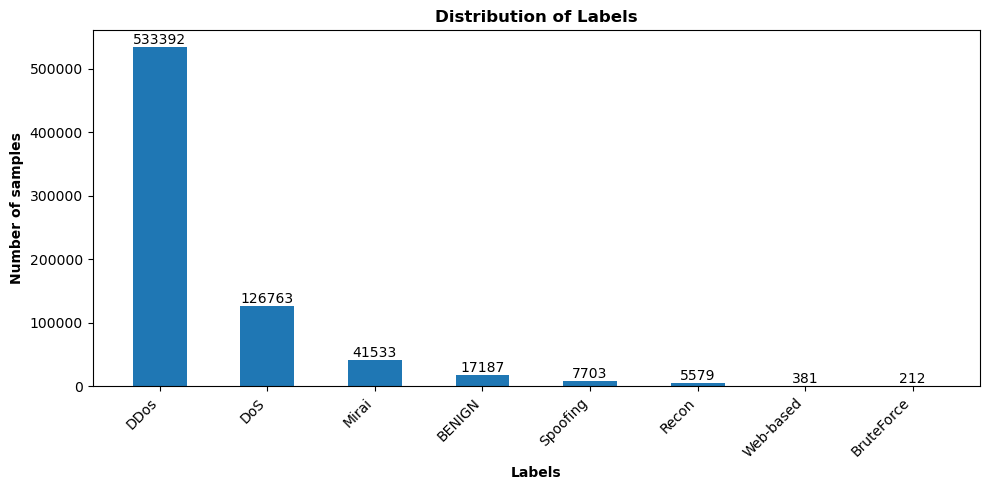

In [4]:
x_label_distribute = np.array(
   df["label"].value_counts().index.tolist())
y_label_distribute = np.array(
    df["label"].value_counts().values.tolist())
bar_width = 0.5

# Creating figure
fig = plt.figure(figsize=(10, 5))

# Drawing bar graph
bars = plt.bar(x_label_distribute, y_label_distribute, width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.0f}'.format)

plt.xlabel('Labels', weight='bold')
plt.ylabel('Number of samples', weight='bold')
plt.title('Distribution of Labels', weight='bold')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('reduced_attacks_list.png')

plt.show()

# 3. Normalization

In [7]:
label = pd.DataFrame(df.label)

In [8]:
label

,label
0,DDos
1,DoS
2,DDos
3,DoS
4,DoS
...,...
732745,DDos
732746,DoS
732747,DDos
732748,DDos


In [5]:
def scaleStandardData(dataFrame, numeric_cols):
  scaler = preprocessing.StandardScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame, numeric_cols):
  scaler = preprocessing.MinMaxScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame, numeric_cols):
  dataFrame = scaleStandardData(dataFrame, numeric_cols)
  dataFrame = scaleMinMaxData(dataFrame, numeric_cols)
  return dataFrame

In [6]:
# Dividing the dataset into 2 parts for training and testing
from sklearn.model_selection import train_test_split

# Assuming 'df' is your pandas dataframe
# Separate features (X) and target variable (y)
features = df.drop('label', axis=1)  # Replace 'target_column_name' with your actual target column name
target = df['label']

# Split data into training and testing sets with 70% for training
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [14]:
X_train

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
28575,0.000000,54.00,6.00,64.00,1.344099,1.344099,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.336181e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
124557,0.000000,54.00,6.00,64.00,73.635309,73.635309,0.0,1.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334922e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
385782,0.000000,54.00,6.00,64.00,5.459005,5.459005,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333113e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
329742,0.000000,0.00,1.00,64.00,2.004430,2.004430,0.0,0.0,0.0,0.0,...,42.000000,0.000000,42.00,8.312898e+07,9.5,9.165151,0.00000,0.000000,0.00,141.55
410788,0.571478,68763.78,16.89,62.35,213038.187412,213038.187412,0.0,0.0,0.0,0.0,...,113.290974,79.546055,90.42,8.301583e+07,9.5,13.428683,112.67788,25752.611575,0.41,141.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0.000000,54.00,6.00,64.00,3.609968,3.609968,0.0,1.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334383e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
365838,0.000000,54.00,6.00,65.91,79.969951,79.969951,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333173e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
131932,0.000000,54.00,6.00,64.00,8.068646,8.068646,0.0,1.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334835e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55
671155,0.000000,54.00,6.00,65.91,1.245155,1.245155,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.331451e+07,9.5,10.392305,0.00000,0.000000,0.00,141.55


In [15]:
y_train

28575      DDos
124557     DDos
385782     DDos
329742     DDos
410788      DoS
          ...  
259178     DDos
365838     DDos
131932     DDos
671155     DDos
121958    Recon
Name: label, Length: 512925, dtype: object

In [7]:
# Setting the label to number to get through the feature selection. They only allow numeric data
y_train = y_train.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})
y_test = y_test.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})

In [8]:
# converting float64 to float128
# float_cols = X_train.select_dtypes(include=['float64']).columns
# X_train[float_cols] = X_train[float_cols].astype(np.float128)
# float_cols = X_test.select_dtypes(include=['float64']).columns
# X_test[float_cols] = X_test[float_cols].astype(np.float128)

numeric_features = X_train.select_dtypes(include='number').columns
# Scaling data
X_train = scaleData(X_train, numeric_features)

In [18]:
X_train.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
28575,0.000000,0.000006,0.127660,0.25098,1.831190e-07,1.831190e-07,0.0,0.0,1.0,0.0,...,0.001535,0.000000,0.000919,0.497268,0.607143,1.097532e-02,0.000000,0.000000,0.00,0.57697
124557,0.000000,0.000006,0.127660,0.25098,1.003201e-05,1.003201e-05,0.0,1.0,0.0,1.0,...,0.001535,0.000000,0.000919,0.497193,0.607143,1.097532e-02,0.000000,0.000000,0.00,0.57697
385782,0.000000,0.000006,0.127660,0.25098,7.437304e-07,7.437304e-07,0.0,0.0,0.0,0.0,...,0.001535,0.000000,0.000919,0.497086,0.607143,1.097532e-02,0.000000,0.000000,0.00,0.57697
329742,0.000000,0.000000,0.021277,0.25098,2.730819e-07,2.730819e-07,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.495880,0.607143,2.081668e-17,0.000000,0.000000,0.00,0.57697
410788,0.000006,0.007006,0.359362,0.24451,2.902415e-02,2.902415e-02,0.0,0.0,0.0,0.0,...,0.009118,0.007234,0.003709,0.495205,0.607143,3.813184e-02,0.007246,0.000188,0.41,0.57697


# 4. Feature selection

## 4.1 Random Forest Importance

In [45]:
# Method 1: Random Forest Importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

model = RandomForestRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

In [46]:
# Mapping the scores to the associated features, and arrange from the highest score
features_list = X_train.columns.tolist()
rf_features_score_dict = dict(zip(features_list, importance))
rf_arranged_dict = dict(sorted(rf_features_score_dict.items(), key=lambda item: item[1], reverse=True))
rf_arranged_dict

{'IAT': 0.7151554868916757,
 'rst_count': 0.09965459220190531,
 'flow_duration': 0.04319147763371113,
 'Srate': 0.014941599921313147,
 'Rate': 0.01417551385842846,
 'Weight': 0.011969512142365296,
 'Header_Length': 0.011579534473572182,
 'urg_count': 0.011023678642399266,
 'Number': 0.010402789054860116,
 'Duration': 0.008697309574413153,
 'Protocol Type': 0.006333134272096569,
 'syn_count': 0.006272284169152868,
 'Min': 0.005437576717991114,
 'Tot size': 0.004682207890066572,
 'fin_count': 0.004661259734336435,
 'Tot sum': 0.004479798066917769,
 'HTTPS': 0.003567734742654789,
 'Max': 0.002968646109876111,
 'ack_count': 0.002917329999228651,
 'Covariance': 0.0027301160729706684,
 'Magnitue': 0.0026255365763801284,
 'AVG': 0.0025097974077216384,
 'Std': 0.0022326329543565643,
 'Radius': 0.002210599024537965,
 'HTTP': 0.0019001216813108813,
 'Variance': 0.0016061653514646112,
 'SSH': 0.0004017859798998696,
 'syn_flag_number': 0.0003421642220083778,
 'TCP': 0.0003330822650209074,
 'ack_fl

In [54]:
list(rf_arranged_dict.keys())[:30]

['IAT',
 'rst_count',
 'flow_duration',
 'Srate',
 'Rate',
 'Weight',
 'Header_Length',
 'urg_count',
 'Number',
 'Duration',
 'Protocol Type',
 'syn_count',
 'Min',
 'Tot size',
 'fin_count',
 'Tot sum',
 'HTTPS',
 'Max',
 'ack_count',
 'Covariance',
 'Magnitue',
 'AVG',
 'Std',
 'Radius',
 'HTTP',
 'Variance',
 'SSH',
 'syn_flag_number',
 'TCP',
 'ack_flag_number']

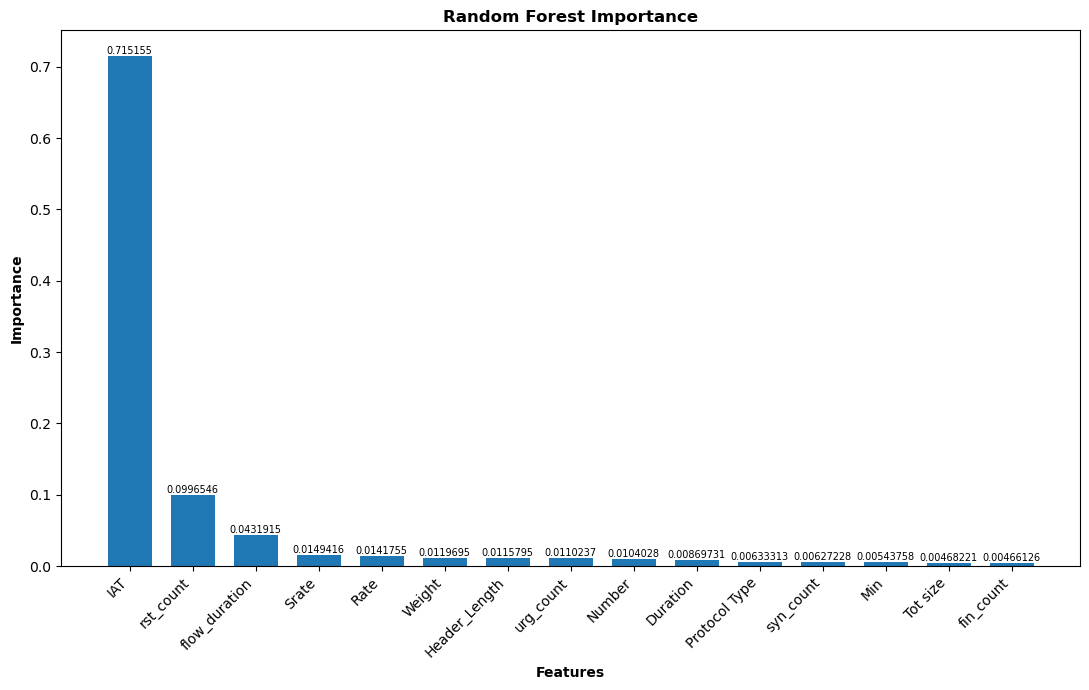

In [49]:
# Creating figure
fig = plt.figure(figsize=(11, 7))
bar_width = 0.7
# summarize feature importance
# plot feature importance
bars = plt.bar(list(rf_arranged_dict.keys())[:15], list(rf_arranged_dict.values())[:15], width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=7)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.1f}'.format)

plt.xlabel('Features', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.title('Random Forest Importance', weight='bold')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('rf_importance.png')
plt.show()

## 4.2 Recursive Feature Elimination

In [44]:
# Method 2: Recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=30, step=1)
rfe.fit(X_train, y_train.astype(int))


X_rfeTrain=rfe.transform(X_train)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(numeric_features[i] for i in rfecolindex_train)
rfecolname_train

['flow_duration',
 'Header_Length',
 'Protocol Type',
 'Duration',
 'Rate',
 'Srate',
 'syn_flag_number',
 'psh_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'urg_count',
 'rst_count',
 'HTTP',
 'HTTPS',
 'SSH',
 'UDP',
 'Tot sum',
 'Min',
 'Max',
 'AVG',
 'Std',
 'Tot size',
 'IAT',
 'Number',
 'Magnitue',
 'Radius',
 'Covariance',
 'Variance',
 'Weight']

In [43]:
rfecolname_train[0]

'flow_duration'

## 4.3 Logistic Regression Feature Importance

In [17]:
# Method 3: Recursive feature elimination
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
importance = model.coef_
avg_importance = np.mean(np.abs(importance), axis=0)

# # Mapping the scores to the associated features, and arrange from the highest score
# features_list = X_train.columns.tolist()
# lg_features_score_dict = dict(zip(features_list, avg_importance))
# lg_arranged_dict = dict(sorted(lg_features_score_dict.items(), key=lambda item: item[1], reverse=True))
# lg_arranged_dict

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Mapping the scores to the associated features, and arrange from the highest score
features_list = X_train.columns.tolist()
lg_features_score_dict = dict(zip(features_list, avg_importance))
lg_arranged_dict = dict(sorted(lg_features_score_dict.items(), key=lambda item: item[1], reverse=True))
lg_arranged_dict

{'Header_Length': 4.706819252649131,
 'Magnitue': 4.456958822477084,
 'Variance': 3.8725537709755775,
 'Duration': 3.238037713123959,
 'Min': 3.1960481326978334,
 'Protocol Type': 3.1826627856138434,
 'Tot sum': 1.9777488431644779,
 'rst_count': 1.9472309851762217,
 'TCP': 1.760827851143919,
 'AVG': 1.6536544858207347,
 'syn_flag_number': 1.4850098005055175,
 'fin_flag_number': 1.4393192178069711,
 'ICMP': 1.4161457697445061,
 'ack_flag_number': 1.3770144981999755,
 'psh_flag_number': 1.3270893786442841,
 'IPv': 1.3193542819133157,
 'LLC': 1.3193542819133157,
 'UDP': 1.1725845197458429,
 'urg_count': 1.1497345329033186,
 'HTTP': 1.1070969625232205,
 'syn_count': 1.0709485508109935,
 'rst_flag_number': 1.0056152116188377,
 'Tot size': 1.002941555006106,
 'Radius': 0.8871680749872382,
 'Std': 0.8858248591159319,
 'HTTPS': 0.7779730367039597,
 'Max': 0.6699010410543534,
 'IAT': 0.5965103230091227,
 'ack_count': 0.5250559595696083,
 'Weight': 0.5096485160717887,
 'Number': 0.39772774631202

In [25]:
list(lg_arranged_dict.keys())[25:30]

['HTTPS', 'Max', 'IAT', 'ack_count', 'Weight']

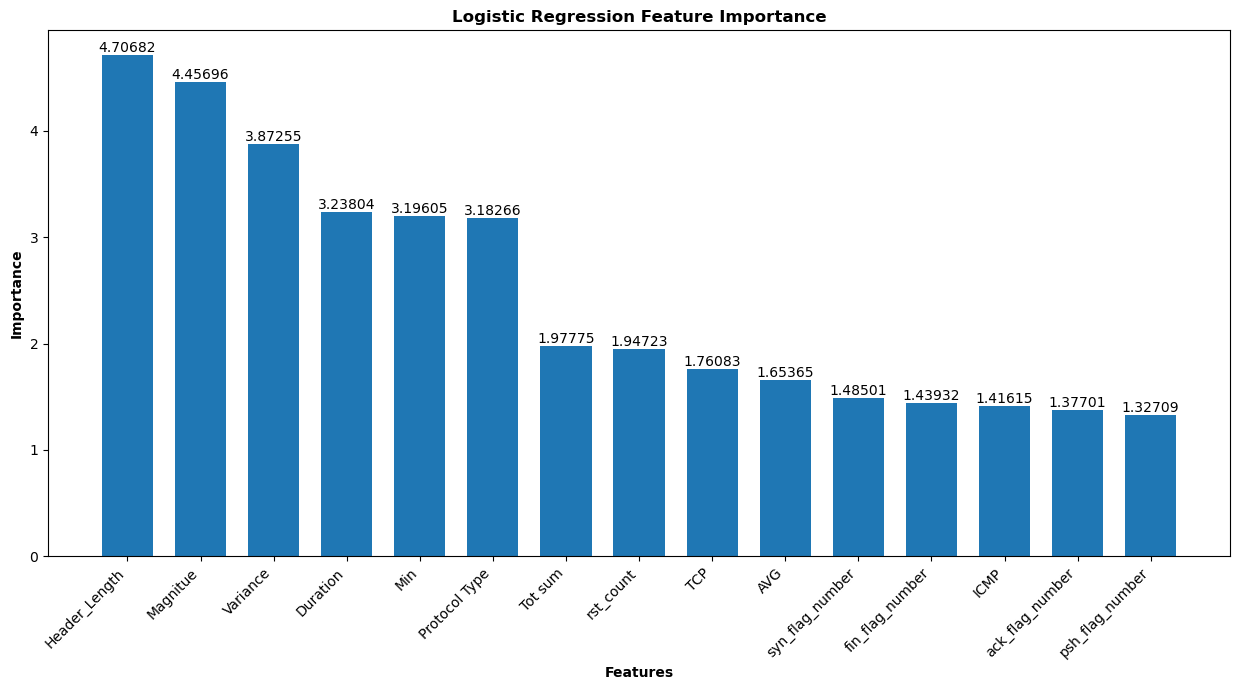

In [20]:
# Creating figure
fig = plt.figure(figsize=(12.5, 7))
bar_width = 0.7
# summarize feature importance
# plot feature importance
bars = plt.bar(list(lg_arranged_dict.keys())[:15], list(lg_arranged_dict.values())[:15], width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.0f}'.format)

plt.xlabel('Features', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.title('Logistic Regression Feature Importance', weight='bold')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('lg_importance.png')
plt.show()

## 4.4 XGBoost Regression Feature Importance

In [29]:
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [62]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_

# Mapping the scores to the associated features, and arrange from the highest score
features_list = X_train.columns.tolist()
xg_features_score_dict = dict(zip(features_list, importance))
xg_arranged_dict = dict(sorted(xg_features_score_dict.items(), key=lambda item: item[1], reverse=True))
xg_arranged_dict

{'IAT': 0.4330917,
 'rst_count': 0.11130658,
 'Number': 0.10696635,
 'HTTPS': 0.051735975,
 'SSH': 0.027134223,
 'flow_duration': 0.024122888,
 'Weight': 0.023556529,
 'fin_count': 0.02299297,
 'Rate': 0.0217092,
 'HTTP': 0.019665563,
 'Tot sum': 0.017181017,
 'Header_Length': 0.0113215735,
 'syn_count': 0.010913815,
 'Magnitue': 0.010709039,
 'UDP': 0.009881517,
 'Min': 0.0079780035,
 'urg_count': 0.007822966,
 'TCP': 0.0068539307,
 'Protocol Type': 0.006421161,
 'Duration': 0.0063246908,
 'ack_count': 0.006208,
 'DNS': 0.006117026,
 'Tot size': 0.0060693747,
 'Variance': 0.005160677,
 'AVG': 0.0050753434,
 'Max': 0.00507394,
 'ack_flag_number': 0.004442908,
 'Covariance': 0.0043858043,
 'Std': 0.0043394687,
 'Radius': 0.004221864,
 'syn_flag_number': 0.003950016,
 'IPv': 0.003635796,
 'psh_flag_number': 0.0030873118,
 'ARP': 0.0005427248,
 'Srate': 0.0,
 'Drate': 0.0,
 'fin_flag_number': 0.0,
 'rst_flag_number': 0.0,
 'ece_flag_number': 0.0,
 'cwr_flag_number': 0.0,
 'Telnet': 0.0,
 

In [68]:
list(xg_arranged_dict.keys())[:30]

['IAT',
 'rst_count',
 'Number',
 'HTTPS',
 'SSH',
 'flow_duration',
 'Weight',
 'fin_count',
 'Rate',
 'HTTP',
 'Tot sum',
 'Header_Length',
 'syn_count',
 'Magnitue',
 'UDP',
 'Min',
 'urg_count',
 'TCP',
 'Protocol Type',
 'Duration',
 'ack_count',
 'DNS',
 'Tot size',
 'Variance',
 'AVG',
 'Max',
 'ack_flag_number',
 'Covariance',
 'Std',
 'Radius']

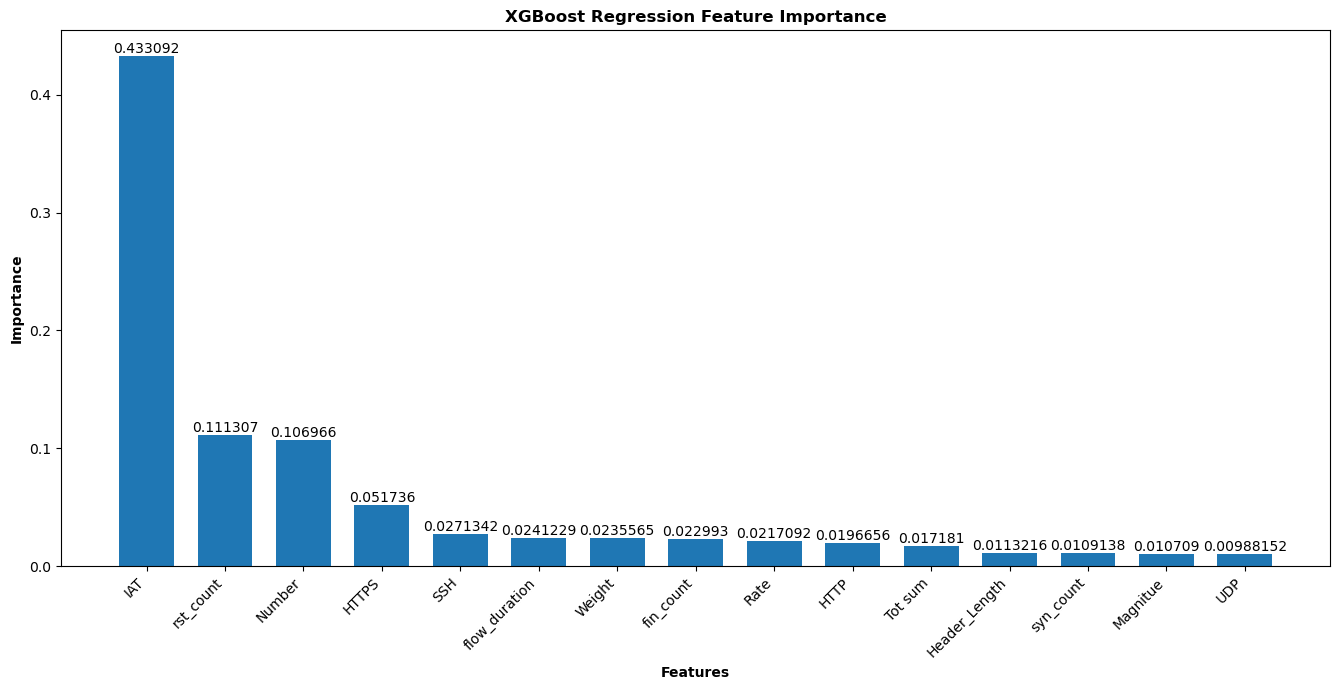

In [66]:
# Creating figure
fig = plt.figure(figsize=(13.5, 7))
bar_width = 0.7
# summarize feature importance
# plot feature importance
bars = plt.bar(list(xg_arranged_dict.keys())[:15], list(xg_arranged_dict.values())[:15], width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.1f}'.format)

plt.xlabel('Features', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.title('XGBoost Regression Feature Importance', weight='bold')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('xg_importance.png')
plt.show()

## 4.5 Information Gain

In [20]:
from sklearn.feature_selection import mutual_info_classif
ig_scores = mutual_info_classif(X_train, y_train, random_state=0)
ig_scores

array([2.02654229e-01, 3.54934264e-01, 3.13274378e-01, 2.12598596e-01,
       1.55047437e-01, 1.54561333e-01, 1.02827162e-03, 3.07062282e-02,
       3.21236715e-02, 2.70548972e-02, 2.91210143e-02, 6.88317929e-02,
       0.00000000e+00, 0.00000000e+00, 5.19568179e-02, 9.94764166e-02,
       4.19961268e-02, 1.74092149e-01, 1.82826589e-01, 4.40723197e-03,
       5.30921819e-02, 0.00000000e+00, 2.02814440e-04, 2.13971450e-04,
       1.77963680e-03, 7.53338971e-04, 1.12418810e-01, 3.36527033e-02,
       4.22052570e-04, 6.94441668e-04, 6.46803206e-02, 6.80857218e-02,
       6.66390970e-02, 4.05114714e-01, 3.82655672e-01, 4.14195998e-01,
       4.06169692e-01, 2.01199268e-01, 4.21707489e-01, 8.52565663e-01,
       2.45267190e-01, 4.08966658e-01, 2.00393535e-01, 1.97223545e-01,
       1.78822429e-01, 2.27532122e-01])

In [21]:
# Mapping the scores to the associated features, and arrange from the highest score
features_list = X_train.columns.tolist()
ig_features_score_dict = dict(zip(features_list, ig_scores))
ig_arranged_dict = dict(sorted(ig_features_score_dict.items(), key=lambda item: item[1], reverse=True))
ig_arranged_dict

{'IAT': 0.8525656629381312,
 'Tot size': 0.42170748878919895,
 'Max': 0.4141959982839989,
 'Magnitue': 0.4089666581324207,
 'AVG': 0.4061696917945745,
 'Tot sum': 0.40511471423287393,
 'Min': 0.38265567197619266,
 'Header_Length': 0.35493426418878804,
 'Protocol Type': 0.3132743782083418,
 'Number': 0.24526718993592422,
 'Weight': 0.22753212155416702,
 'Duration': 0.21259859630846778,
 'flow_duration': 0.20265422855937154,
 'Std': 0.20119926826997725,
 'Radius': 0.2003935349664696,
 'Covariance': 0.19722354486020022,
 'rst_count': 0.1828265885257454,
 'Variance': 0.17882242881512322,
 'urg_count': 0.17409214907660453,
 'Rate': 0.1550474368407173,
 'Srate': 0.15456133282634776,
 'TCP': 0.11241880980997343,
 'syn_count': 0.09947641659358131,
 'ack_flag_number': 0.06883179293872388,
 'IPv': 0.06808572180154027,
 'LLC': 0.06663909704040405,
 'ICMP': 0.06468032060777085,
 'HTTPS': 0.053092181884960565,
 'ack_count': 0.05195681788298234,
 'fin_count': 0.04199612678187403,
 'UDP': 0.033652703

In [40]:
ig_arranged_dict.keys()

dict_keys(['IAT', 'Tot size', 'Max', 'Magnitue', 'AVG', 'Tot sum', 'Min', 'Header_Length', 'Protocol Type', 'Number', 'Weight', 'Duration', 'flow_duration', 'Std', 'Radius', 'Covariance', 'rst_count', 'Variance', 'urg_count', 'Rate', 'Srate', 'TCP', 'syn_count', 'ack_flag_number', 'IPv', 'LLC', 'ICMP', 'HTTPS', 'ack_count', 'fin_count', 'UDP', 'syn_flag_number', 'fin_flag_number', 'psh_flag_number', 'rst_flag_number', 'HTTP', 'SSH', 'Drate', 'IRC', 'ARP', 'DHCP', 'SMTP', 'Telnet', 'ece_flag_number', 'cwr_flag_number', 'DNS'])

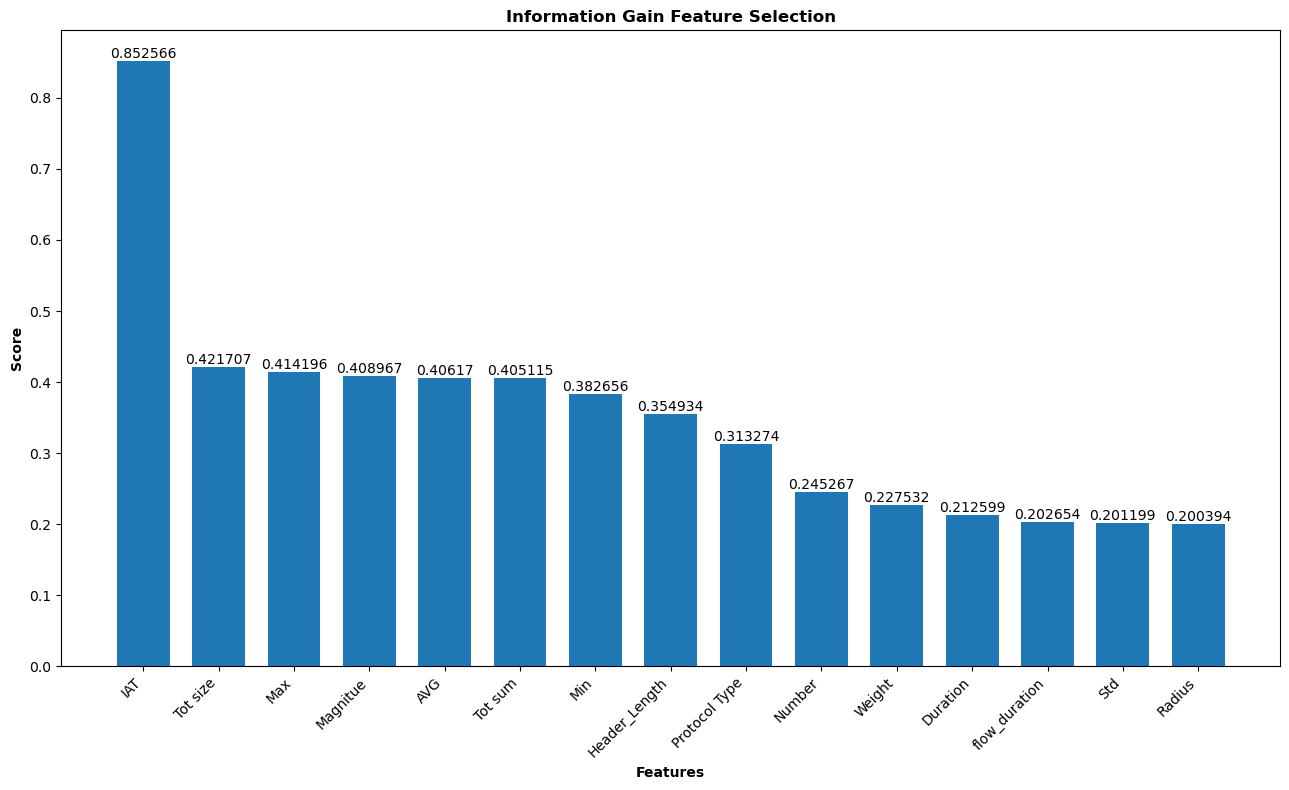

In [29]:
# Creating figure
fig = plt.figure(figsize=(13, 8))
bar_width = 0.7
# summarize feature importance
# plot feature importance
bars = plt.bar(list(ig_arranged_dict.keys())[:15], list(ig_arranged_dict.values())[:15], width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.1f}'.format)

plt.xlabel('Features', weight='bold')
plt.ylabel('Score', weight='bold')
plt.title('Information Gain Feature Selection', weight='bold')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('ig_importance.png')
plt.show()

## 4.6 Permutation Feature Importance

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# importance = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error').importances_mean
# perform permutation importance
results = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean

# Mapping the scores to the associated features, and arrange from the highest score
features_list = X_train.columns.tolist()
pf_features_score_dict = dict(zip(features_list, importance))
pf_arranged_dict = dict(sorted(pf_features_score_dict.items(), key=lambda item: item[1], reverse=True))
pf_arranged_dict

In [ ]:
# Creating figure
fig = plt.figure(figsize=(10, 5))
bar_width = 0.5
# summarize feature importance
# plot feature importance
bars = plt.bar(list(pf_arranged_dict.keys())[:10], list(pf_arranged_dict.values())[:10], width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Rotating axis x
plt.xticks(rotation=45, ha='right')

# Setting axis y
plt.gca().yaxis.set_major_formatter('{:.0f}'.format)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('pf_importance.png')
plt.show()